In [1]:
from dsamfs.io_nopsrdada import initialize_uvh5_file, update_uvh5_file
from dsautils import cnf
from pkg_resources import resource_filename
import yaml
import numpy as np
import glob
import astropy.units as u
import json
from astropy.time import Time
import dsacalib.constants as ct
import h5py
from antpos.utils import get_itrf
from dsacalib.fringestopping import calc_uvw
from pyuvdata import UVData
from dsacalib.ms_io import uvh5_to_ms, read_caltable, extract_vis_from_ms
from casatasks import virtualconcat
from dsacalib.routines import get_files_for_cal
import dsacalib.calib as dc
from casatasks import tclean, mstransform
import casatools as cc
import matplotlib.pyplot as plt
from astropy.coordinates import Angle
from casacore.tables import table
from pyuvdata import UVData
from dsacalib.preprocess import remove_outrigger_delays
import os
import shutil
from dsacalib.plotting import summary_plot

def get_mjd(armed_mjd, utc_start, specnum):
    return armed_mjd+utc_start*4*8.192e-6/86400+(1/(250e6/8192/2)*specnum/ct.SECONDS_PER_DAY)

def get_blen(antennas):
    ant_itrf = get_itrf(
        latlon_center=(ct.OVRO_LAT*u.rad, ct.OVRO_LON*u.rad, ct.OVRO_ALT*u.m)
    ).loc[antennas]
    xx = np.array(ant_itrf['dx_m'])
    yy = np.array(ant_itrf['dy_m'])
    zz = np.array(ant_itrf['dz_m'])
    # Get uvw coordinates
    nants = len(antennas)
    nbls = (nants*(nants+1))//2
    blen = np.zeros((nbls, 3))
    bname = []
    k = 0
    for i in range(nants):
        for j in range(i, nants):
            blen[k, :] = np.array([
                xx[i]-xx[j],
                yy[i]-yy[j],
                zz[i]-zz[j]
            ])
            bname += ['{0}-{1}'.format(
                antennas[i],
                antennas[j]
            )]
            k += 1
    return blen, bname

def plot_image(imname, verbose=False, outname=None, show=True, cellsize='0.2arcsec'):
    """Plots an image from the casa-generated image file.
    """
    error = 0
    ia = cc.image()
    error += not ia.open(imname)
    dd = ia.summary()
    # dd has shape npixx, npixy, nch, npol
    npixx = dd['shape'][0]
    if verbose:
        print('Image shape: {0}'.format(dd['shape']))
    imvals = ia.getchunk(0, int(npixx))[:, :, 0, 0]
    #imvals = fftshift(imvals)
    error += ia.done()
    if verbose:
        peakx, peaky = np.where(imvals.max() == imvals)
        print('Peak SNR at pix ({0},{1}) = {2}'.format(peakx[0], peaky[0],
                                                       imvals.max()/
                                                       imvals.std()))
        print('Value at peak: {0}'.format(imvals.max()))
        print('Value at origin: {0}'.format(imvals[imvals.shape[0]//2,
                                                   imvals.shape[1]//2]))

    _, ax = plt.subplots(1, 1, figsize=(15, 8))
    pim = ax.imshow(
        imvals.transpose(),
        interpolation='none',
        origin='lower',
        extent=[
            (-imvals.shape[0]/2*Angle(cellsize)).to_value(u.arcsecond),
            (imvals.shape[0]/2*Angle(cellsize)).to_value(u.arcsecond),
            (-imvals.shape[1]/2*Angle(cellsize)).to_value(u.arcsecond),
            (imvals.shape[1]/2*Angle(cellsize)).to_value(u.arcsecond)
        ]
    )
    plt.colorbar(pim)
    ax.axvline(0, color='white', alpha=0.5)
    ax.axhline(0, color='white', alpha=0.5)
    ax.set_xlabel('l (arcsec)')
    ax.set_ylabel('m (arcsec)')
    if outname is not None:
        plt.savefig('{0}_image.png'.format(outname))
    if not show:
        plt.close()
    if error > 0:
        print('{0} errors occured during imaging'.format(error))

In [2]:
myconf = cnf.Conf()
corrparams = myconf.get('corr')
pols_corr = ['BB', 'BA', 'AB', 'AA']
ntint = 3052*2
nfint = 1

In [3]:
paramfile = resource_filename('dsacalib', 'data/T3_parameters.yaml')
pt_dec = +02.06*u.deg
name = '2021-05-25_3C273'
sourcename = '3C273'

In [4]:
tstart = Time(59359.17686156, format='mjd')
tstart.isot

'2021-05-25T04:14:40.839'

In [5]:
specnum = 21344356
# datestring = '22may21'
# t3dir = '/mnt/data/dsa110/T3/'
# jsonfiles = glob.glob('{0}/corr??/{1}/fl*.{2}.json'.format(t3dir, datestring, specnum))
# with open(jsonfiles[0]) as jsonf:
#     metad = json.load(jsonf)
# itime = list(metad.keys())[0]
# tstart = Time(
#     get_mjd(
#         metad[itime]['armed_mjd'],
#         metad[itime]['utc_start'],
#         metad[itime]['specnum']
#     ),
#     format='mjd'
# )
# tstart.isot

In [6]:
with open(paramfile) as yamlf:
    params = yaml.load(yamlf, Loader=yaml.FullLoader)['T3corr']

In [7]:
antenna_order = params['antennas']
fobs = params['f0_GHz']+params['deltaf_MHz']*1e-3*nfint*(
    np.arange(params['nchan']//nfint)+0.5)
antenna_order = params['antennas']
nant = len(antenna_order)
nbls = (nant*(nant+1))//2
tsamp = params['deltat_s']*ntint*u.s
tobs = tstart + (np.arange(params['nsubint']//ntint)+0.5)*tsamp
blen, bname = get_blen(params['antennas'])

/home/user/anaconda3/envs/casa/lib/python3.6/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [8]:
bu, bv, bw = calc_uvw(
    blen,
    tobs.mjd,
    'HADEC',
    np.zeros(len(tobs))*u.rad,
    np.ones(len(tobs))*pt_dec
)
buvw = np.array([bu, bv, bw]).T

In [9]:
for corr, ch0 in params['ch0'].items():
    fobs_corr = fobs[ch0//nfint:(ch0+params['nchan_corr'])//nfint]
    data = np.fromfile(
        '/mnt/data/dsa110/T3/imaging_test/25may21_{0}/{1}_fl_1.out.{0}.corr'.format(
            specnum,
            corr
        ),
        dtype=np.float32
    )
    data = data.reshape(-1, 2)
    data = data[..., 0] + 1.j*data[..., 1]
    data = data.reshape(-1, nbls, len(fobs_corr), 4)[..., [0, -1]]
    outname = '/mnt/data/dsa110/imaging/{1}_{0}.hdf5'.format(corr, name)
    with h5py.File(outname, 'w') as fhdf5:
        initialize_uvh5_file(
            fhdf5,
            len(fobs_corr),
            2,
            pt_dec.to_value(u.rad),
            antenna_order,
            fobs_corr
        )
        update_uvh5_file(
            fhdf5,
            data,
            tobs.jd,
            tsamp,
            bname,
            buvw,
            np.ones(data.shape, np.float32)
        )
    UV = UVData()
    UV.read(outname, file_type='uvh5', run_check_acceptability=False)
    remove_outrigger_delays(UV)
    UV.write_uvh5(outname, clobber=True, run_check_acceptability=False)

Telescope OVRO_MMA is not in known_telescopes.
key applied_delays_ns in extra_keywords is longer than 8 characters. It will be truncated to 8 if written to uvfits or miriad file formats.
key ha_phase_center in extra_keywords is longer than 8 characters. It will be truncated to 8 if written to uvfits or miriad file formats.
key phase_center_dec in extra_keywords is longer than 8 characters. It will be truncated to 8 if written to uvfits or miriad file formats.
key phase_center_epoch in extra_keywords is longer than 8 characters. It will be truncated to 8 if written to uvfits or miriad file formats.


File exists; clobbering
File exists; clobbering
File exists; clobbering
File exists; clobbering
File exists; clobbering
File exists; clobbering
File exists; clobbering
File exists; clobbering
File exists; clobbering
File exists; clobbering
File exists; clobbering
File exists; clobbering
File exists; clobbering
File exists; clobbering
File exists; clobbering
File exists; clobbering


In [10]:
msname_cal = '/mnt/data/dsa110/calibration/2021-05-25_J122906+020305'
calname = 'J122906+020305'
spwmap = list(range(16))
bad_antennas=['1', '2', '3', '4', '5']
bad_uvrange='2~27m'
date = '2021-05-25'
msname = '/home/user/data/imaging/{0}'.format(name)

In [11]:
caltable = resource_filename('dsacalib', 'data/calibrator_sources_dec+02p06.csv')
filenames = get_files_for_cal(
    caltable,
    duration=15*u.min,
    date_specifier='{0}*'.format(date),
    refcorr='03'
)
filenames[date][calname]
cal = filenames[date][calname]['cal']

In [12]:
cal.name, cal.ra, cal.dec

('J122906+020305', <Angle 187.27670833 deg>, <Angle 2.05141667 deg>)

In [13]:
flist = glob.glob('/mnt/data/dsa110/imaging/{0}_corr??.hdf5'.format(name))
print(flist)
uvh5_to_ms(
    flist,
    msname,
    ra=cal.ra,
    dec=cal.dec
)

['/mnt/data/dsa110/imaging/2021-05-25_3C273_corr09.hdf5', '/mnt/data/dsa110/imaging/2021-05-25_3C273_corr05.hdf5', '/mnt/data/dsa110/imaging/2021-05-25_3C273_corr01.hdf5', '/mnt/data/dsa110/imaging/2021-05-25_3C273_corr06.hdf5', '/mnt/data/dsa110/imaging/2021-05-25_3C273_corr14.hdf5', '/mnt/data/dsa110/imaging/2021-05-25_3C273_corr12.hdf5', '/mnt/data/dsa110/imaging/2021-05-25_3C273_corr07.hdf5', '/mnt/data/dsa110/imaging/2021-05-25_3C273_corr03.hdf5', '/mnt/data/dsa110/imaging/2021-05-25_3C273_corr15.hdf5', '/mnt/data/dsa110/imaging/2021-05-25_3C273_corr16.hdf5', '/mnt/data/dsa110/imaging/2021-05-25_3C273_corr02.hdf5', '/mnt/data/dsa110/imaging/2021-05-25_3C273_corr04.hdf5', '/mnt/data/dsa110/imaging/2021-05-25_3C273_corr11.hdf5', '/mnt/data/dsa110/imaging/2021-05-25_3C273_corr10.hdf5', '/mnt/data/dsa110/imaging/2021-05-25_3C273_corr08.hdf5', '/mnt/data/dsa110/imaging/2021-05-25_3C273_corr13.hdf5']
['/mnt/data/dsa110/imaging/2021-05-25_3C273_corr09.hdf5', '/mnt/data/dsa110/imaging/202

Combined frequencies are not evenly spaced. This will make it impossible to write this data out to some file types.
key applied_delays_ns in extra_keywords is longer than 8 characters. It will be truncated to 8 as required by the uvfits file format.
key ha_phase_center in extra_keywords is longer than 8 characters. It will be truncated to 8 as required by the uvfits file format.
key phase_center_dec in extra_keywords is longer than 8 characters. It will be truncated to 8 as required by the uvfits file format.
key phase_center_epoch in extra_keywords is longer than 8 characters. It will be truncated to 8 as required by the uvfits file format.


Successful read/write open of default-locked table /home/user/data/imaging/2021-05-25_3C273.ms/ANTENNA: 8 columns, 117 rows
added column MODEL_DATA
'added column CORRECTED_DATA
added column IMAGING_WEIGHT
defined keyword CHANNEL_SELECTION in column MODEL_DATA
Successful read/write open of default-locked table /home/user/data/imaging/2021-05-25_3C273.ms: 26 columns, 9300 rows


In [38]:
tables_to_remove = [
    '{0}_{1}_2kcal'.format(msname_cal, cal.name),
    '{0}_{1}_kcal'.format(msname_cal, cal.name),
    '{0}_{1}_bkcal'.format(msname_cal, cal.name),
    '{0}_{1}_gacal'.format(msname_cal, cal.name),
    '{0}_{1}_gpcal'.format(msname_cal, cal.name),
    '{0}_{1}_bcal'.format(msname_cal, cal.name),
    '{0}_{1}_2gcal'.format(msname_cal, cal.name)
]
for path in tables_to_remove:
    if os.path.exists(path):
        shutil.rmtree(path)
print('resetting flags')
# Reset flags in the measurement set
dc.reset_flags(msname_cal, datacolumn='data')
dc.reset_flags(msname_cal, datacolumn='model')
dc.reset_flags(msname_cal, datacolumn='corrected')
print('flagging baselines')
error = dc.flag_baselines(msname_cal, uvrange=bad_uvrange)
error = dc.flag_zeros(msname_cal)
print('flagging antaennas')
if bad_antennas is not None:
    for ant in bad_antennas:
        error = dc.flag_antenna(msname_cal, ant)
print('delay cal')
error = dc.delay_calibration(
    msname_cal,
    cal.name,
    refants=['101', '103']
)

print('bandpass and gain cal')
error = dc.gain_calibration(
    msname_cal,
    cal.name,
    refant='101',
    blbased=False,
    forsystemhealth=True,
    keepdelays=True
)

resetting flags
flagging baselines
flagging antaennas
delay cal
Successful readonly open of default-locked table /mnt/data/dsa110/calibration/2021-05-25_J122906+020305_J122906+020305_ref101_kcal: 13 columns, 117 rows
Successful readonly open of default-locked table /mnt/data/dsa110/calibration/2021-05-25_J122906+020305_J122906+020305_ref103_kcal: 13 columns, 117 rows
Successful read/write open of default-locked table /mnt/data/dsa110/calibration/2021-05-25_J122906+020305_J122906+020305_ref103_kcal: 13 columns, 117 rows
Successful readonly open of default-locked table /mnt/data/dsa110/calibration/2021-05-25_J122906+020305_J122906+020305_ref101_2kcal: 13 columns, 1755 rows
Successful readonly open of default-locked table /mnt/data/dsa110/calibration/2021-05-25_J122906+020305_J122906+020305_ref103_2kcal: 13 columns, 1755 rows
Successful read/write open of default-locked table /mnt/data/dsa110/calibration/2021-05-25_J122906+020305_J122906+020305_ref103_2kcal: 13 columns, 1755 rows
bandpass

Successful readonly open of default-locked table /mnt/data/dsa110/calibration/2021-05-25_J122906+020305_J122906+020305_2kcal: 13 columns, 1755 rows
Successful readonly open of default-locked table /mnt/data/dsa110/calibration/2021-05-25_J122906+020305_J122906+020305_kcal: 13 columns, 117 rows
Successful readonly open of default-locked table /mnt/data/dsa110/calibration/2021-05-25_J122906+020305_J122906+020305_bcal: 13 columns, 117 rows
Successful readonly open of default-locked table /mnt/data/dsa110/calibration/2021-05-25_J122906+020305.ms/SPECTRAL_WINDOW: 14 columns, 1 rows
Successful readonly open of default-locked table /mnt/data/dsa110/calibration/2021-05-25_J122906+020305_J122906+020305_2gcal: 13 columns, 3510 rows
Successful readonly open of default-locked table /mnt/data/dsa110/calibration/2021-05-25_J122906+020305.ms: 26 columns, 91000 rows
Successful readonly open of default-locked table /mnt/data/dsa110/calibration/2021-05-25_J122906+020305.ms/SPECTRAL_WINDOW: 14 columns, 1 

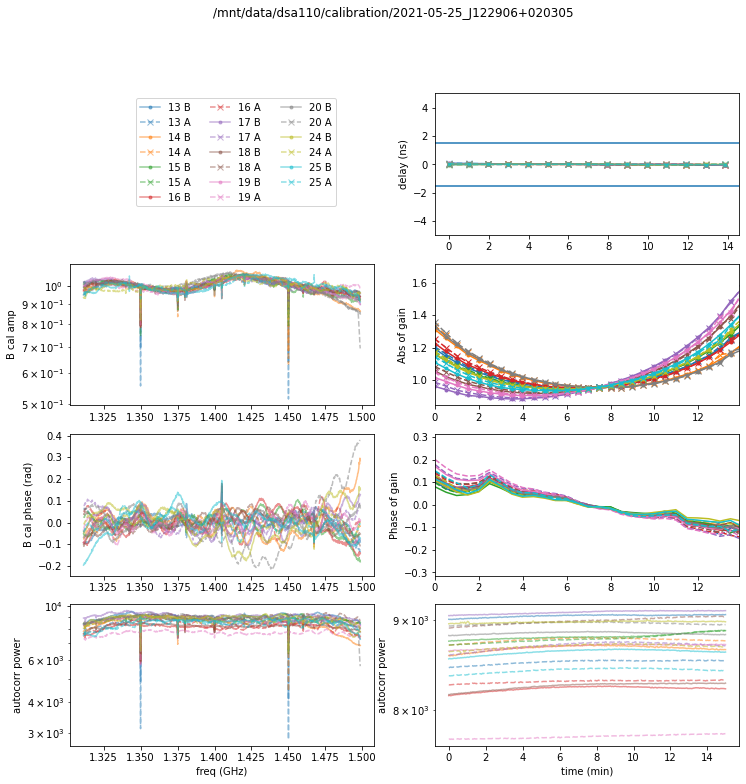

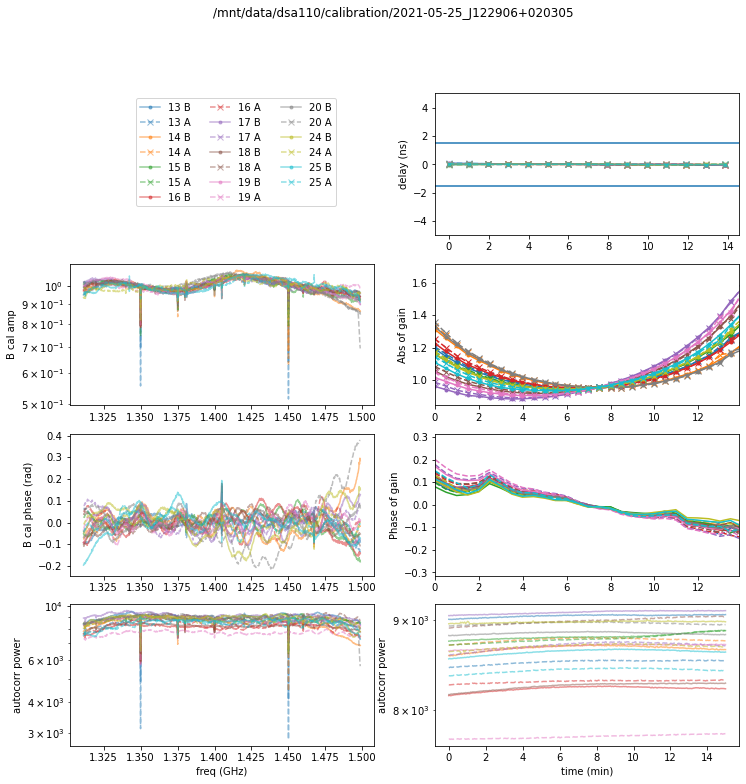

In [39]:
summary_plot(
    msname_cal,
    cal.name,
    2,
    ['B', 'A'],
    [13, 14, 15, 16, 17, 18, 19, 20, 24, 25]
)

In [14]:
spwmap = [-1]
calibration_tables = [
    {
        'type': 'K',
        'spwmap': spwmap,
        'table': '{0}_{1}_kcal'.format(msname_cal, calname)
    },
    {
        'type': 'B',
        'spwmap': spwmap,
        'table': '{0}_{1}_bacal'.format(msname_cal, calname)
    },
    {
        'type': 'B',
        'spwmap': spwmap,
        'table': '{0}_{1}_bpcal'.format(msname_cal, calname)
    },
    {
        'type': 'G',
        'spwmap': spwmap,
        'table': '{0}_{1}_gacal'.format(msname_cal, calname)
    },
    {
        'type': 'G',
        'spwmap': spwmap,
        'table': '{0}_{1}_gpcal'.format(msname_cal, calname)
    }
]

In [15]:
for column in ['data', 'corrected']:
    dc.reset_flags(msname, column)
dc.flag_baselines(msname, uvrange=bad_uvrange)
dc.flag_zeros(msname)
for antenna in bad_antennas:
    dc.flag_antenna(msname, antenna)
dc.apply_and_correct_calibrations(msname, calibration_tables)

0

In [17]:
msname

'/home/user/data/imaging/2021-05-25_3C273'

In [21]:
tclean(
    '{0}.ms'.format(msname),
    datacolumn='corrected',
    imsize=16384,
    cell='0.2arcsec',
    imagename='{0}_16384'.format(msname)
)

{}

Image shape: [16384 16384     1     1]
Peak SNR at pix (8177,8260) = 8.409116927113256
Value at peak: 0.01023186556994915
Value at origin: 0.009193225763738155
1 errors occured during imaging


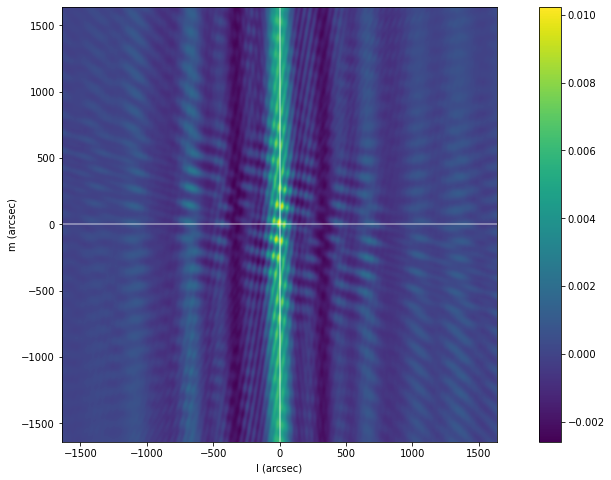

In [22]:
plot_image('{0}_16384.image'.format(msname), verbose=True)

In [23]:
ia = cc.image()
ia.open('{0}_16384.image'.format(msname))
dd = ia.summary()

center_ra = dd['refval'][0]*u.rad
center_dec = dd['refval'][1]*u.rad
source_ra = ((dd['refval'][0] + 1/np.cos(center_dec)*(8177-dd['refpix'][0])*dd['incr'])[0]*u.rad).to(u.deg)
center_ra.to(u.deg), source_ra, cal.ra, (source_ra-cal.ra).to(u.arcsecond)

(<Quantity 187.27670833 deg>,
 <Quantity 187.2775422 deg>,
 <Angle 187.27670833 deg>,
 <Angle 3.00192391 arcsec>)

In [24]:
tables_to_remove = [
    '{0}_{1}_2kcal'.format(msname, cal.name),
    '{0}_{1}_kcal'.format(msname, cal.name),
    '{0}_{1}_bkcal'.format(msname, cal.name),
    '{0}_{1}_gacal'.format(msname, cal.name),
    '{0}_{1}_gpcal'.format(msname, cal.name),
    '{0}_{1}_bcal'.format(msname, cal.name),
    '{0}_{1}_2gcal'.format(msname, cal.name)
]
for path in tables_to_remove:
    if os.path.exists(path):
        shutil.rmtree(path)
print('resetting flags')
# Reset flags in the measurement set
dc.reset_flags(msname, datacolumn='data')
dc.reset_flags(msname, datacolumn='model')
dc.reset_flags(msname, datacolumn='corrected')
print('flagging baselines')
error = dc.flag_baselines(msname, uvrange=bad_uvrange)
error = dc.flag_zeros(msname)
print('flagging antennas')
if bad_antennas is not None:
    for ant in bad_antennas:
        error = dc.flag_antenna(msname, ant)
print('delay cal')
error = dc.delay_calibration(
    msname,
    cal.name,
    refants=['101', '103']
)
# shutil.copytree(
#     '{0}_{1}_kcal'.format(msname_cal, cal.name),
#     '{0}_{1}_kcal'.format(msname, cal.name)
# )

print('bandpass and gain cal')
error = dc.gain_calibration(
    msname,
    cal.name,
    refant='101',
    blbased=False,
    forsystemhealth=True,
    keepdelays=True
)

resetting flags
flagging baselines
flagging antennas
delay cal
Successful readonly open of default-locked table /home/user/data/imaging/2021-05-25_3C273_J122906+020305_ref101_kcal: 13 columns, 117 rows
Successful readonly open of default-locked table /home/user/data/imaging/2021-05-25_3C273_J122906+020305_ref103_kcal: 13 columns, 117 rows
Successful read/write open of default-locked table /home/user/data/imaging/2021-05-25_3C273_J122906+020305_ref103_kcal: 13 columns, 117 rows
Successful readonly open of default-locked table /home/user/data/imaging/2021-05-25_3C273_J122906+020305_ref101_2kcal: 13 columns, 117 rows
Successful readonly open of default-locked table /home/user/data/imaging/2021-05-25_3C273_J122906+020305_ref103_2kcal: 13 columns, 117 rows
Successful read/write open of default-locked table /home/user/data/imaging/2021-05-25_3C273_J122906+020305_ref103_2kcal: 13 columns, 117 rows
bandpass and gain cal


In [25]:
spwmap = [-1]
calibration_tables = [
    {
        'type': 'K',
        'spwmap': spwmap,
        'table': '{0}_{1}_kcal'.format(msname, calname)
    },
    {
        'type': 'B',
        'spwmap': spwmap,
        'table': '{0}_{1}_bacal'.format(msname, calname)
    },
    {
        'type': 'B',
        'spwmap': spwmap,
        'table': '{0}_{1}_bpcal'.format(msname, calname)
    },
    {
        'type': 'G',
        'spwmap': spwmap,
        'table': '{0}_{1}_gacal'.format(msname, calname)
    },
    {
        'type': 'G',
        'spwmap': spwmap,
        'table': '{0}_{1}_gpcal'.format(msname, calname)
    }
]

In [26]:
for column in ['data', 'corrected']:
    dc.reset_flags(msname, column)
dc.flag_baselines(msname, uvrange=bad_uvrange)
dc.flag_zeros(msname)
for antenna in bad_antennas:
    dc.flag_antenna(msname, antenna)
dc.apply_and_correct_calibrations(msname, calibration_tables)

0

In [28]:
tclean(
    '{0}.ms'.format(msname),
    datacolumn='corrected',
    imsize=16384,
    cell='0.2arcsec',
    imagename='{0}_selfcal_16384'.format(msname)
)

{}

Image shape: [16384 16384     1     1]
Peak SNR at pix (8192,8209) = 8.727008934597785
Value at peak: 0.9673946499824524
Value at origin: 0.9621612429618835
1 errors occured during imaging


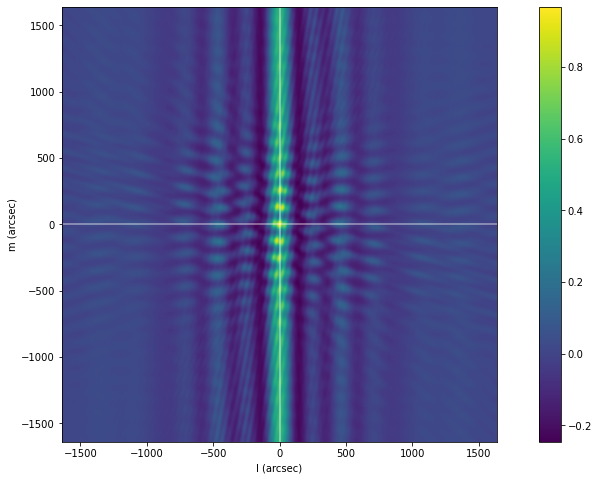

In [29]:
plot_image('{0}_selfcal_16384.image'.format(msname), verbose=True)

Successful readonly open of default-locked table /home/user/data/imaging/2021-05-25_3C273_J122906+020305_kcal: 13 columns, 117 rows
Successful readonly open of default-locked table /mnt/data/dsa110/calibration/2021-05-25_J122906+020305_J122906+020305_kcal: 13 columns, 117 rows
24 -0.07891846
25 -0.056152344
26 -0.007446289
27 -0.020843506
28 -0.026641846
29 -0.047302246
30 -0.027160645
31 -0.040252686
32 -0.059509277
33 -0.038909912
34 0.0068359375
35 -0.031799316
19 -0.67666626
17 5.1972046
20 3.0335388
18 -7.6029663
15 -0.27954102
16 0.26898193
14 0.0
13 -0.029724121
100 -1675.5942
101 -837.9409
102 -5771.601
116 -0.009399414
103 -0.11651611
1 -1675.7654
2 -1675.7654
3 -1675.7654
4 -1675.7654
5 -1675.7654


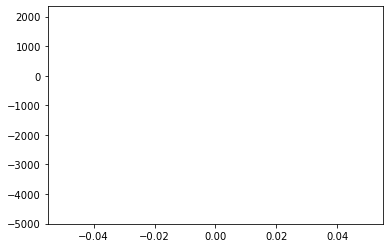

In [31]:
vals, time, flags, ant1, ant2 = read_caltable('{0}_{1}_kcal'.format(msname, cal.name), cparam=False)
vals_rt, time_rt, flags_rt, ant1_rt, ant2_rt = read_caltable('{0}_{1}_kcal'.format(msname_cal, cal.name), cparam=False)
delay_diff = vals - vals_rt 
colorc = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i, ant in enumerate(antenna_order):
    plt.plot(vals[ant-1, 0, :, 0, 0], color=colorc[i%10])
    plt.plot(vals_rt[ant-1, 0, :, 0, 0], '--', color=colorc[i%10])
    print(ant, (delay_diff[ant-1, ...]-delay_diff[13]).squeeze().mean(0))

In [33]:
vals.shape, vals_rt.shape

((117, 1, 1, 6144, 2), (117, 1, 1, 768, 2))

Successful readonly open of default-locked table /home/user/data/imaging/2021-05-25_3C273_J122906+020305_bpcal: 13 columns, 117 rows
Successful readonly open of default-locked table /mnt/data/dsa110/calibration/2021-05-25_J122906+020305_J122906+020305_bpcal: 13 columns, 117 rows
24 0.062904894
25 0.08012005
26 0.10607222
27 0.12028631
28 0.07340174
29 0.12099755
30 0.17501241
31 0.18965131
32 0.09039474
33 0.073219344


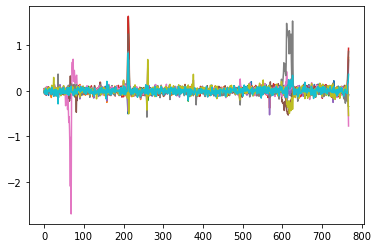

In [34]:
vals, time, flags, ant1, ant2 = read_caltable('{0}_{1}_bpcal'.format(msname, cal.name), cparam=True)
vals = vals.reshape((117, 1, 1, 768, -1, 2)).mean(4)
vals_rt, time_rt, flags_rt, ant1_rt, ant2_rt = read_caltable('{0}_{1}_bpcal'.format(msname_cal, cal.name), cparam=True)
bp_diff = vals - vals_rt 
colorc = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i, ant in enumerate(antenna_order[:10]):
    plt.plot(np.angle(vals[ant-1, 0, :, :, 0]/vals_rt[ant-1, 0, :, :, 0]).flatten(), color=colorc[i%10])
    print(ant, np.sqrt(np.mean(np.angle(vals[ant-1, 0, :, :, 0]/vals_rt[ant-1, 0, :, :, 0]).flatten()**2)))

Successful readonly open of default-locked table /home/user/data/imaging/2021-05-25_3C273_J122906+020305_gpcal: 13 columns, 117 rows
Successful readonly open of default-locked table /mnt/data/dsa110/calibration/2021-05-25_J122906+020305_J122906+020305_gpcal: 13 columns, 117 rows
24 1.8230284
25 1.8089434
26 1.8343263
27 1.8563614
28 1.8580252
29 1.8455076
30 1.8418485
31 1.8533108
32 1.8617238
33 1.8430377
34 1.9118723
35 1.8570902
19 3.1092236
17 -0.67306185
20 -0.35315827
18 -1.0423471
15 1.4634795
16 2.1971152
14 1.8639698
13 1.826609
100 2.0903244
101 -7.452379e-09
102 -0.584917
116 1.0117024
103 1.1026734
1 0.0
2 0.0
3 0.0
4 0.0
5 0.0


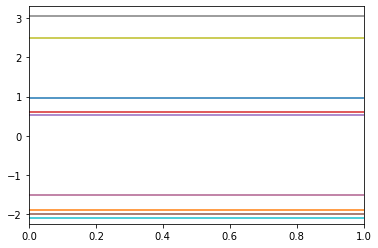

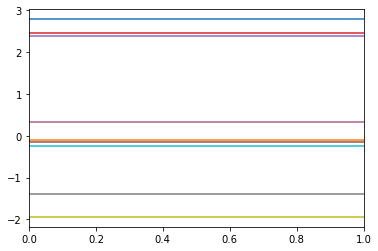

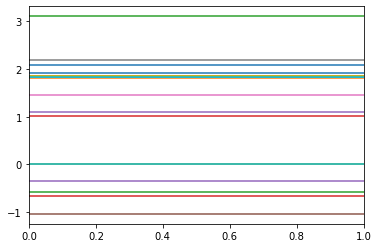

In [35]:
vals, time, flags, ant1, ant2 = read_caltable('{0}_{1}_gpcal'.format(msname, cal.name), cparam=True)
vals_rt, time_rt, flags_rt, ant1_rt, ant2_rt = read_caltable('{0}_{1}_gpcal'.format(msname_cal, cal.name), cparam=True)
gp_diff = vals - vals_rt 
colorc = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.figure()
for i, ant in enumerate(antenna_order[:10]):
    plt.axhline(np.angle(vals_rt[ant-1, 0, :, :, 0]).flatten(), color=colorc[i%10])
plt.figure()
for i, ant in enumerate(antenna_order[:10]):
    plt.axhline(np.angle(vals[ant-1, 0, :, :, 0]).flatten(), color=colorc[i%10])
plt.figure()
for i, ant in enumerate(antenna_order):
    plt.axhline(np.angle(vals[ant-1, 0, :, :, 0]/vals_rt[ant-1, 0, :, :, 0]).flatten(), color=colorc[i%10])
    print(ant, np.mean(np.angle(vals[ant-1, 0, :, :, 0]/vals_rt[ant-1, 0, :, :, 0]).flatten()))